In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [70]:
x = np.linspace(10e-6,20e-6,7)
print(x)

[1.00000000e-05 1.16666667e-05 1.33333333e-05 1.50000000e-05
 1.66666667e-05 1.83333333e-05 2.00000000e-05]


In [71]:
results =[]
for i in range(len(x)):
    print(i)
    base = aligo.make_kat("design_with_IMC_HAM2_FI_OMC", keepComments=True, preserveConstants=True)
    base.phase = 3
    base.L0.P = 20
    #base.IFO.remove_IMC_HAM2(True, False)
    base.maxtem = 2
    base.SRM.T = 0.32

    # Provide about PRG ~ 50
    base.ITMY.L = 20e-6
    base.ITMX.L = 20e-6

    base.ITMY_lens.p = 1/base.ITMY_lens.f.value + x[i]
    base.ITMX_lens.p = 1/base.ITMX_lens.f.value + 10e-6

    base.IFO.CARM.port.phase = -85 #92.5
    base.IFO.PRCL.port.phase = -60 #119.8
    base.IFO.PRCL.quad = 'I'

    base.IFO.SRCL.port = base.IFO.POP_f2
    base.IFO.SRCL.quad = 'I'

    base.IFO.MICH.port.phase = 103.4
    base.IFO.MICH.quad = 'Q'

    
    result = None
    while result is None:
        try:
            base = aligo.setup(base, verbose=False)
            print("Zero-ing locks")
            base.IFO.zero_locks() #Find phases to lock the IFO
            result = 1
        except:
            pass
            print("Ran into a pykat error, trying again")

    #### Maximize the phasing for the sensors.
    for dof in ['CARM', 'PRCL', 'MICH']:
        kat = base.deepcopy()
        dof = kat.IFO.DOFs[dof]
        kat.noxaxis = True
        kat.removeBlock('locks')
        kat.parse( dof.fsig(fsig=1) )
        kat.parse( dof.transfer() )
        kat.parse(f"""
        maximize max {dof.transfer_name()} re {dof.transfer_name()} phase1 -1000 1000 1e-3
        """)
        result= None
        while result is None:
            try:
                print("Finding phasing")
                out = kat.run()
                result = 1
            except:
                pass
                print("Ran into a pykat error, trying again")

        dof.port.phase = out['max'] % 360 - 180
        if dof.quad == 'Q':
            dof.port.phase += 90

        print(dof.name, dof.port.phase, base.IFO.DOFs[dof.name].port.phase)
        base.IFO.DOFs[dof.name].port.phase = dof.port.phase

    base.parse('''
    pd0 POP_DC nPOP
    pd1 POP_RF90_I 90994710.0 max nPOP
    pd1 POP_RF18_I 18198942.0 max nPOP

    pd Prc nPRM2
    pd Pin nPRMs2*
    
    noxaxis
    
    ''')
    
    result = None
    while result is None:
        try:
            print("Running with new phasing")
            out = kat.run()
            result = 1
        except:
            pass
            print("Ran into a pykat error, trying again")
            
    out = base.run()
    results.append(out)

0

Pykat parsing does not preserve inline comments. Moving inline
comments before command

Zero-ing locks
Finding phasing
CARM -83.754338217689 -85
Finding phasing
PRCL -56.29149236943903 -60
Finding phasing
MICH 123.162593503816 103.4
Running with new phasing
1

Pykat parsing does not preserve inline comments. Moving inline
comments before command

Zero-ing locks
Finding phasing
CARM -83.66292585118498 -85
Finding phasing
PRCL -56.19800012775198 -60
Finding phasing
MICH 123.162323565914 103.4
Running with new phasing
2

Pykat parsing does not preserve inline comments. Moving inline
comments before command


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pykat error, trying again

--------------------------------------------------------------
Error from Finesse (See 'pykat.

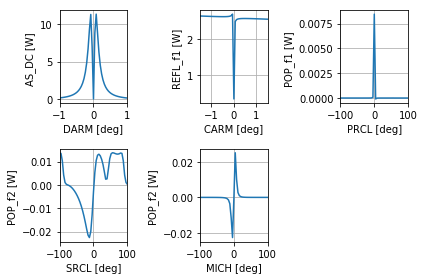

In [72]:
aligo.plot.error_signals(base, xlimits=(-1, 1), steps=50)

In [73]:
POP18 = []
PRC = []
POP_45_Q = []
POP90 = []

SRM_lock = []
PRM_lock = []
AS_DC = []

for i in range(len(results)):
    POP18.append(results[i]['POP_RF18_I'])
    PRC.append(results[i]['Prc'])
    POP_45_Q.append(results[i]['REFL_f1_I'])
    POP90.append(results[i]['POP_RF90_I'])
    SRM_lock.append(results[i]['SRM_lock'])
    PRM_lock.append(results[i]['PRM_lock'])
    AS_DC.append(results[i]['AS_DC'])

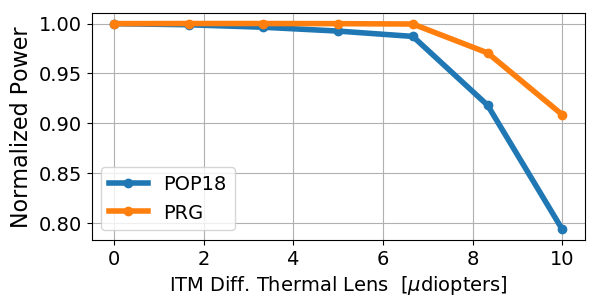

In [77]:
fig = plt.figure(figsize=(14,3),dpi=100)
ax = fig.add_subplot(121)
ax.plot(x*1e6-10,POP18/POP18[0], '-o', linewidth=4, label='POP18')
ax.plot(x*1e6-10,PRC/PRC[0], '-o', linewidth=4, label='PRG')
#ax.plot(x*1e6-10,POP90/POP90[0], linewidth=4, label='POP90')
ax.set_ylabel('Normalized Power', fontsize=16)
ax.set_xlabel('ITM Diff. Thermal Lens  [$\mu$diopters]',fontsize=14)
ax.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)
plt.grid()

#ax = fig.add_subplot(122)
#ax.plot(x*1e6,AS_DC, linewidth=4, label='AS_DC')
#ax.set_ylabel('Normalized Power', fontsize=16)
#ax.set_xlabel('ITM Diff. Thermal Lens  [$\mu$diopters]',fontsize=14)
#ax.tick_params(axis='both', labelsize=14)
#plt.legend(fontsize=14)
#plt.grid()

plt.savefig('POP_18dive.png')